# Model Test #5
* Cleaned/imputed negative values
* estimate data only
* Overall COI Level only target
* Removed other COI Levels and scores as features
* Removed FIPS and year features
* Ran models and confusion matrix
* No class balance and class balance

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import io, s3fs, json, traceback
pd.set_option('display.max_columns', None)
print('Program run at', dt.now())

Program run at 2021-06-10 13:31:14.568109


In [4]:
est = pd.read_csv('s3://bleeding-hearts/workingdata/merge_est.csv')
est.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 148 entries, Unnamed: 0 to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(1), int64(143), object(4)
memory usage: 20.6+ MB


In [5]:
est.drop(columns=['Unnamed: 0','year','FIPS'],inplace=True)
cols=list(est)
all_miss = []
for c in cols:
    if est[c].dtypes != object:
        est.loc[est[c] < 0, c] = np.nan
    if len(est) - est[c].count() == len(est):
        all_miss.append(c)
est.drop(columns=all_miss,inplace=True)
est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 125 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(121), object(4)
memory usage: 17.4+ MB


In [6]:
def assess_missing(df):
    missing_dict = {}
    cols=list(df)
    for c in cols:
        if len(df) - df[c].count() > 0:
             missing_dict[c] = ((len(df) - df[c].count())/len(df))*100
    return missing_dict

In [7]:
est_missing = assess_missing(est)
est_missing

{'COMMUTING TO WORK_Mean travel time to work (minutes)': 0.35149384885764495,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_Total households_Median household income (dollars)': 0.19771528998242532,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_Total households_Mean household income (dollars)': 0.21968365553602814,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With earnings_Mean earnings (dollars)': 0.2251757469244288,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With Social Security_Mean Social Security income (dollars)': 0.5437170474516696,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With retirement income_Mean retirement income (dollars)': 0.8018453427065025,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With Supplemental Security Income_Mean Supplemental Security Income (dollars)': 10.209797891036906,
 'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)_With cash public assistance income_Mean cash

In [8]:
#remove COI columns except for target: Child Opportunity Levels, overall COI, nationally-normed
cols=list(est)
coi_cols=cols[-8:]
coi_cols.remove('Child Opportunity Levels, overall COI, nationally-normed')
clean_cols = [i for i in cols if i not in coi_cols]
est = est[clean_cols]
est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Columns: 118 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Levels, overall COI, nationally-normed
dtypes: float64(117), object(1)
memory usage: 16.4+ MB


In [9]:
#make label lists
cat_labels = list(set(est['Child Opportunity Levels, overall COI, nationally-normed']))

In [10]:
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance
from sklearn.utils import resample

from sklearn.model_selection import train_test_split as tts
from sklearn.impute import SimpleImputer

In [11]:
def viz_cb(y,lst):
    visualizer = ClassBalance(labels=lst)
    visualizer.fit(y)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

In [12]:
def class_balance(df,target):
    print('Raw Value Counts:','\n',df[target].value_counts())
    X = df.loc[:, df.columns != target]
    y = df[target]
    #make a dataframe of value counts and a list of the values in the target
    df1 = y.value_counts().to_frame('count').reset_index(level=0).rename(columns={'index':'value'})
    label_lst = list(df1['value'])
    
    viz_cb(y,label_lst)

    #identify minimum value number and label name
    mi = df1['count'].min()
    name = df1.loc[df1['count'] == mi,'value'].iloc[0]
    print('min value is',name,'in values',label_lst)

    seed = 123
    # Downsample majority class
    
    #use min value number and label name to resample the dataframe
    df2 = pd.concat([resample(df[df[target]== i],
                            replace=False,
                            n_samples=mi,
                            random_state=seed) for i in label_lst if i != name]).append(df[df[target]== name])
    print('Resampled Value Counts:','\n',df2[target].value_counts())
    X = df2.loc[:, df.columns != target]
    y = df2[target]
    viz_cb(y,label_lst)
    return df2

In [13]:
def train_test(X,y):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

In [14]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)
    

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

In [15]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator,label_lst, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=label_lst,
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

In [16]:
import matplotlib as plt
from yellowbrick.classifier import confusion_matrix

def conf_matrix(X,y,estimator,label_lst, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])


    #Create the train and test data
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    model.fit(X, y)
    # Instantiate the visualizer with the classification model
    confusion_matrix(
        model,
        X_train, y_train, X_test, y_test,
        classes=label_lst
    )
    plt.tight_layout()
    plt.show()

## No Class Balance

(14566, 117) (14566,)
(3642, 117) (3642,)
F1 SCORE SVC: 0.7549428822495606


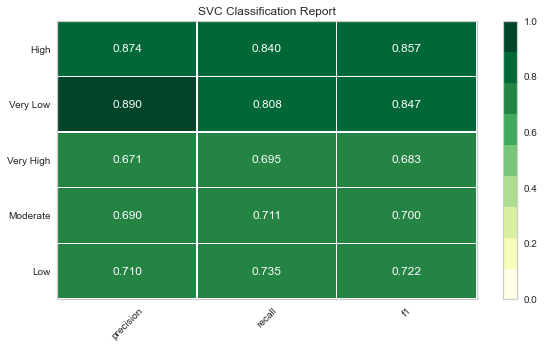

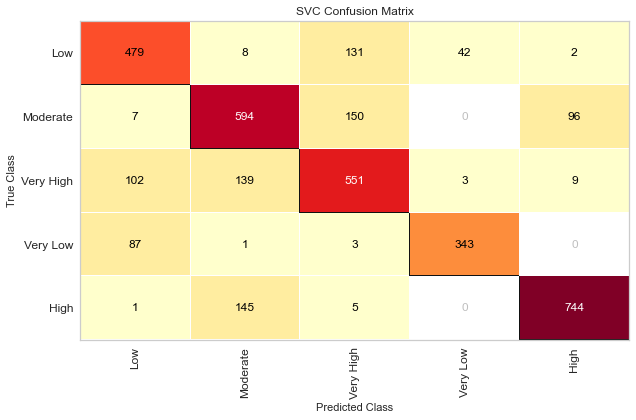

SVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE NuSVC: 0.7259995606326889


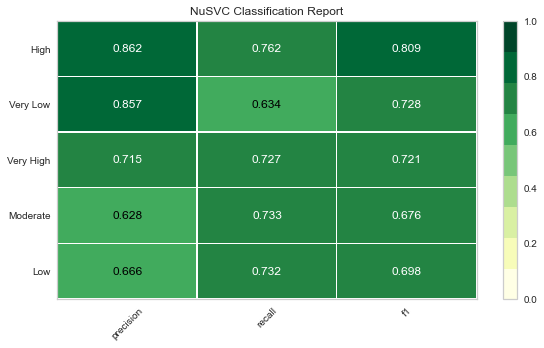

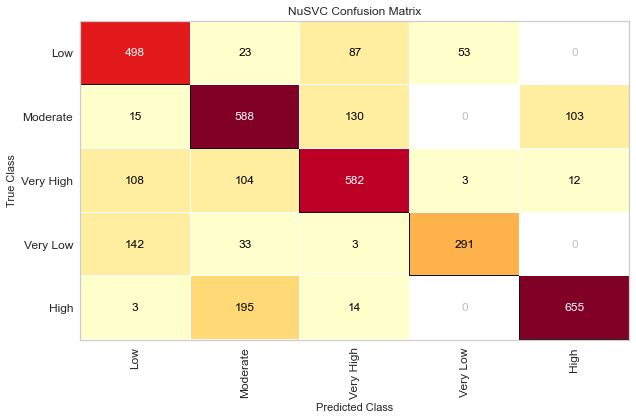

NuSVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LinearSVC: 0.6426296133567663


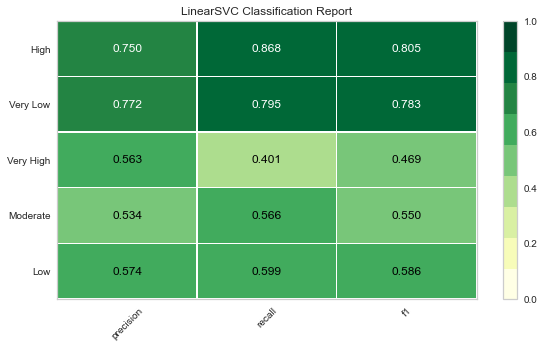

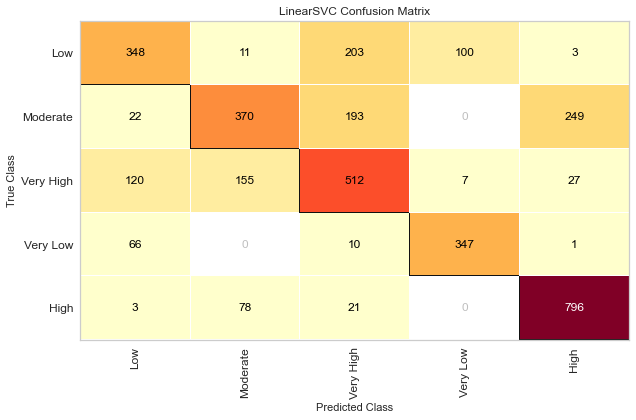

LinearSVC() Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE SGDClassifier: 0.554481546572935


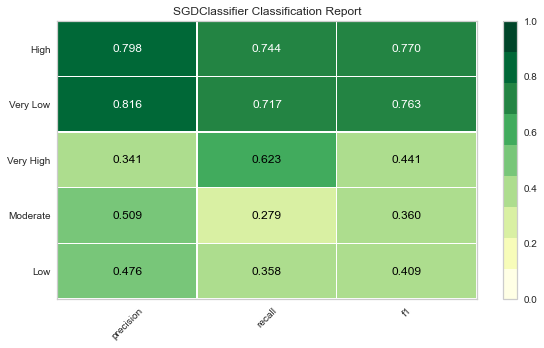

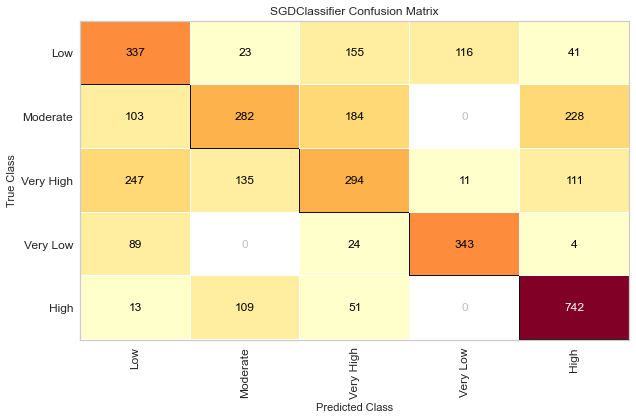

SGDClassifier(max_iter=100) Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE KNeighborsClassifier: 0.6993629173989455


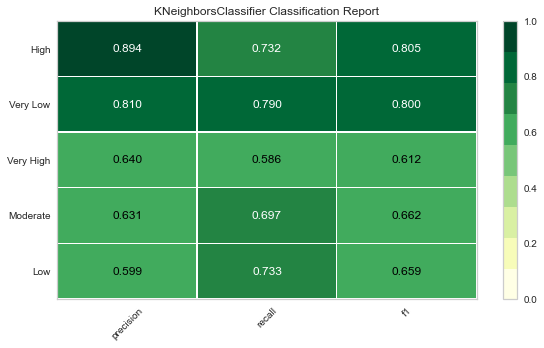

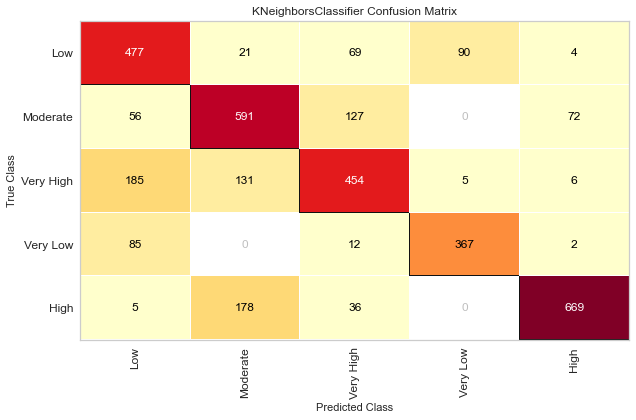

KNeighborsClassifier() Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegression: 0.6457051845342706


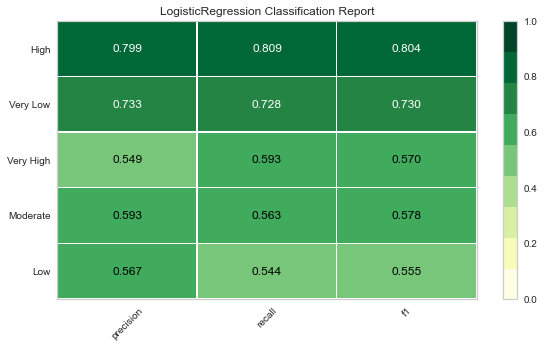

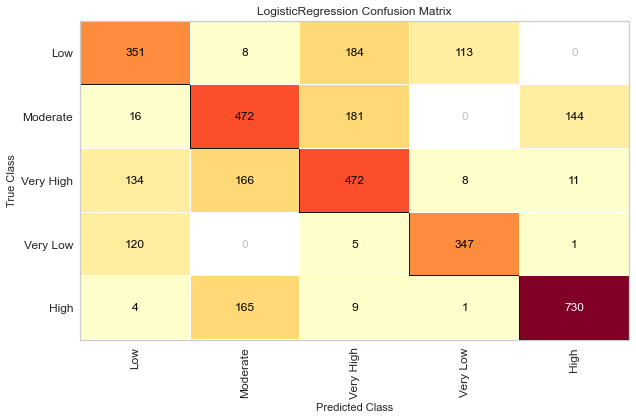

LogisticRegression() Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegressionCV: 0.687280316344464


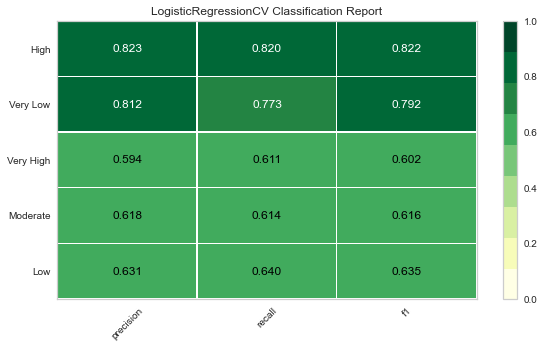

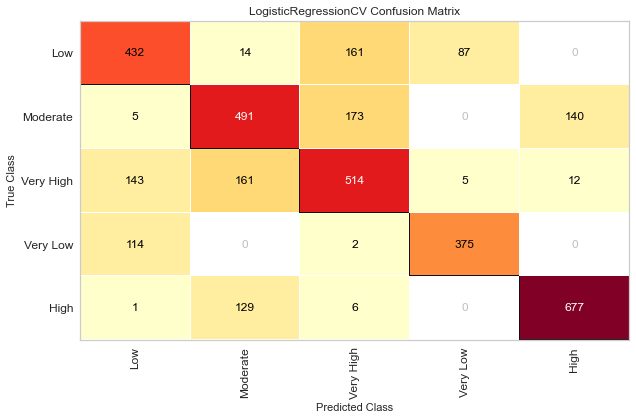

LogisticRegressionCV(cv=3) Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE BaggingClassifier: 0.9871485061511424


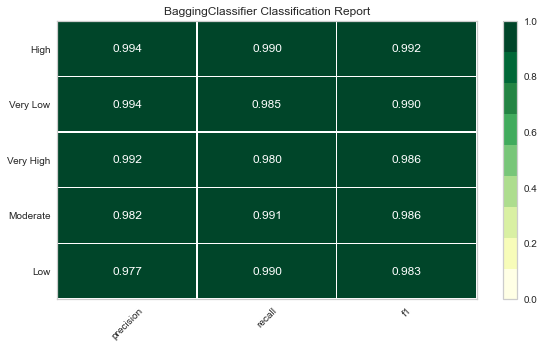

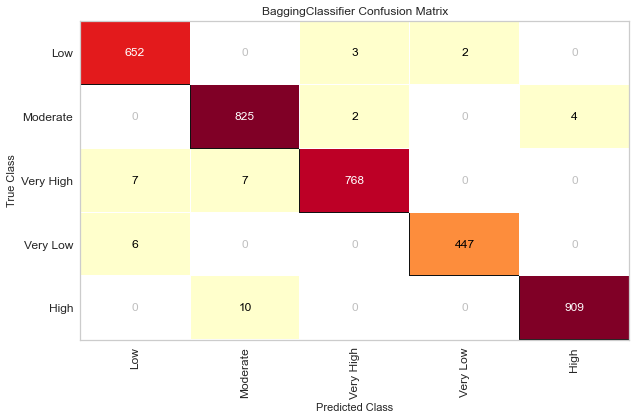

BaggingClassifier() Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE ExtraTreesClassifier: 0.999890158172232


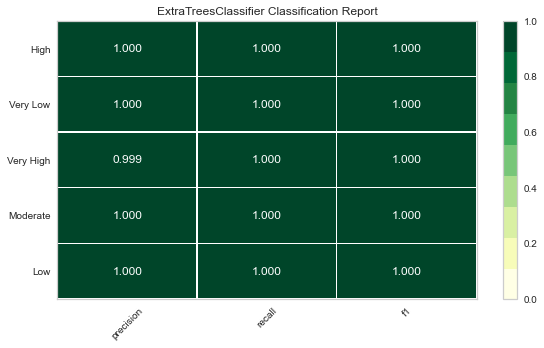

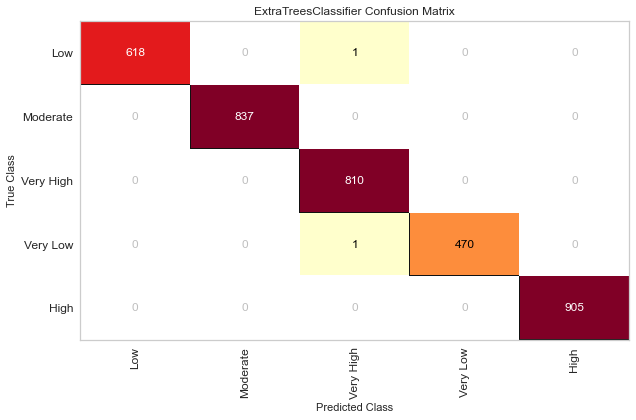

ExtraTreesClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE RandomForestClassifier: 0.999890158172232


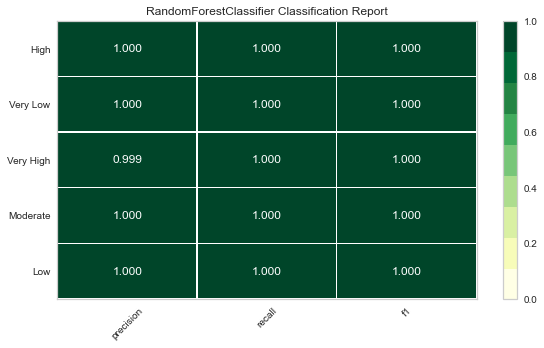

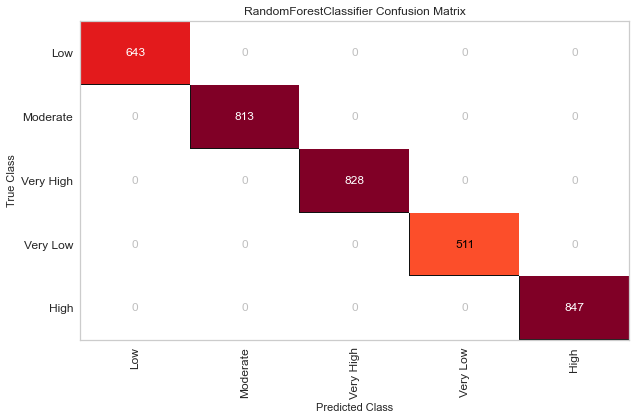

RandomForestClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-17-4d2464274f7e>", line 8, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable


In [17]:
X = est.loc[:, est.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = est['Child Opportunity Levels, overall COI, nationally-normed']
train_test(X,y)
for model in models:
    try:
        score_model(X, y, model)
        visualize_model(X, y, model,cat_labels)
        conf_matrix(X, y, model,cat_labels)
    except Exception as exc:
        print(model, 
              traceback.format_exc(), 
              exc)

## Class Balance

Raw Value Counts: 
 Very Low     4355
Low          4226
Moderate     3990
High         3328
Very High    2309
Name: Child Opportunity Levels, overall COI, nationally-normed, dtype: int64


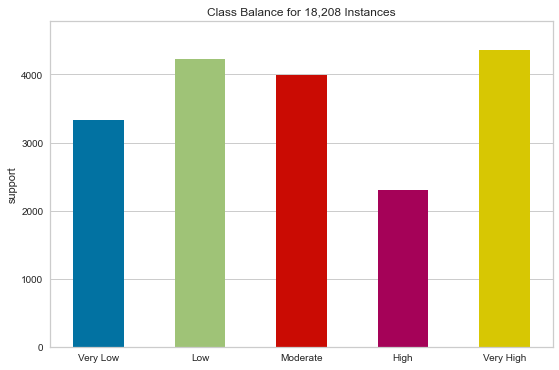

min value is Very High in values ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
Resampled Value Counts: 
 Very Low     2309
High         2309
Very High    2309
Low          2309
Moderate     2309
Name: Child Opportunity Levels, overall COI, nationally-normed, dtype: int64


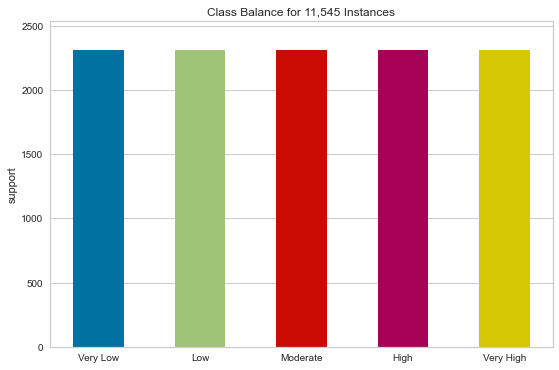

(9236, 117) (9236,)
(2309, 117) (2309,)
F1 SCORE SVC: 0.7614551754006064


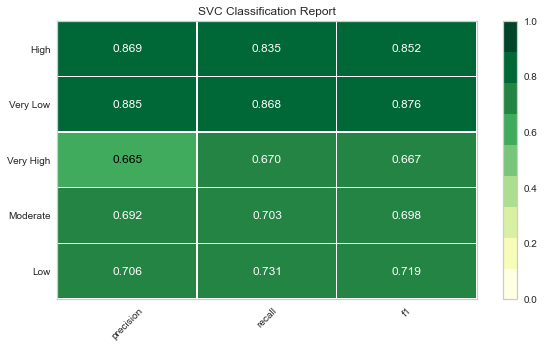

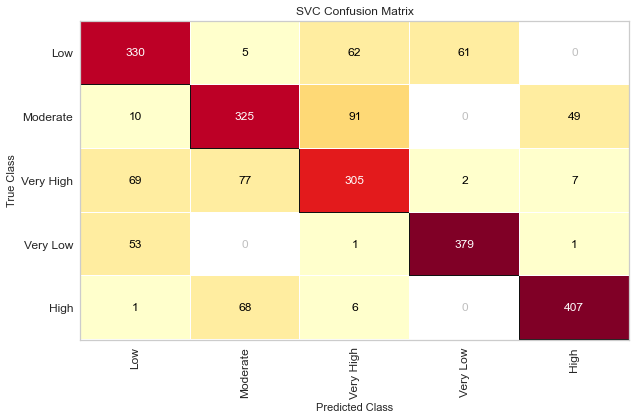

SVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE NuSVC: 0.7303594629709831


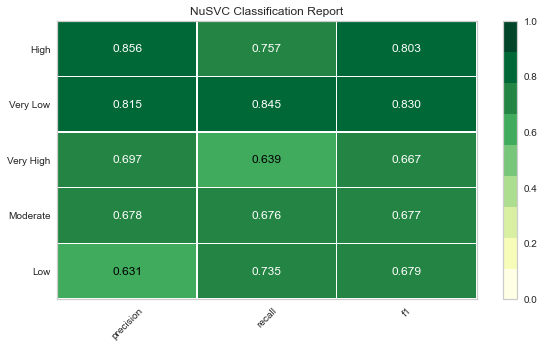

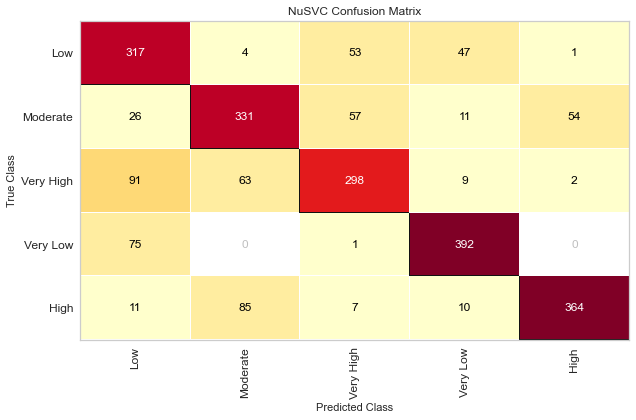

NuSVC(gamma='auto') Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LinearSVC: 0.6402771762667822


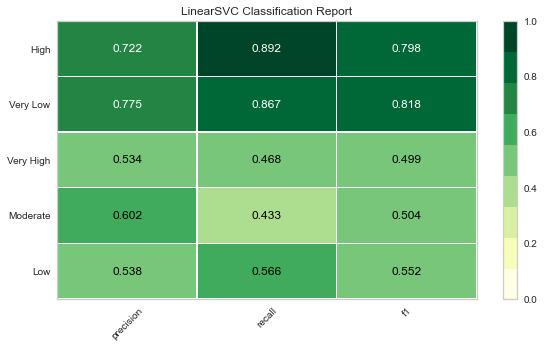

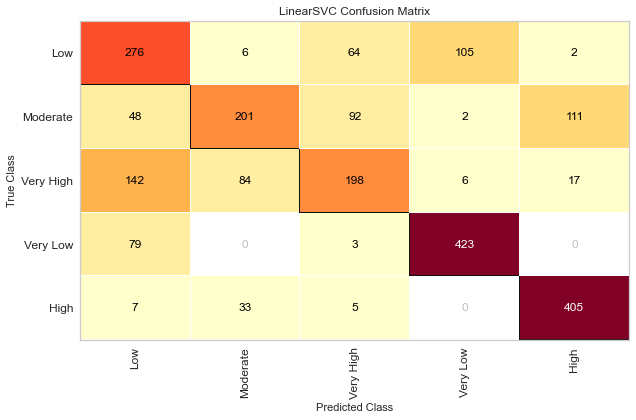

LinearSVC() Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE SGDClassifier: 0.5081853616284105


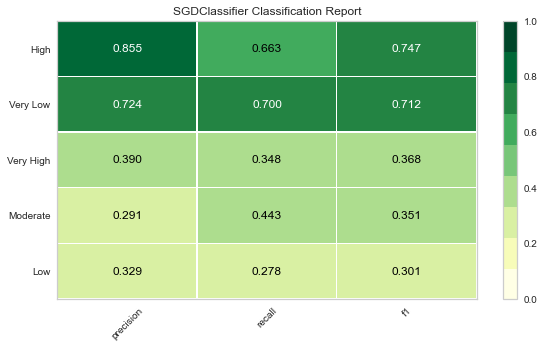

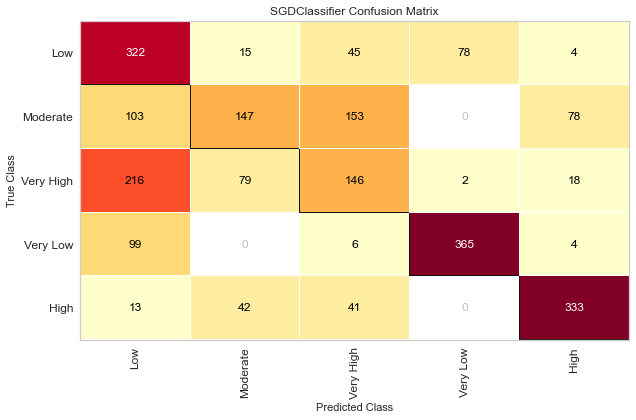

SGDClassifier(max_iter=100) Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE KNeighborsClassifier: 0.706626245127761


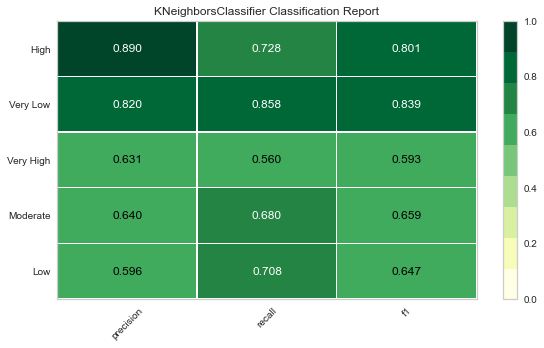

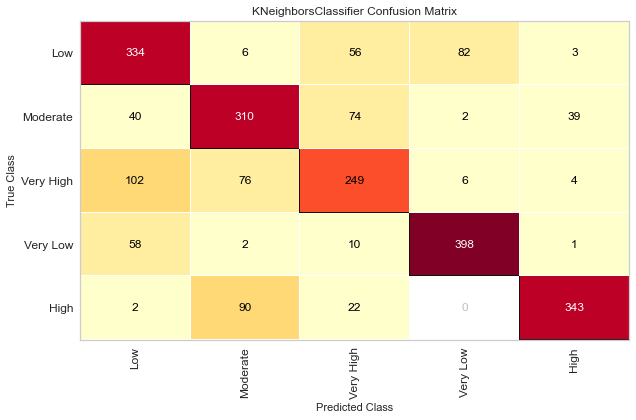

KNeighborsClassifier() Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegression: 0.6557817236899091


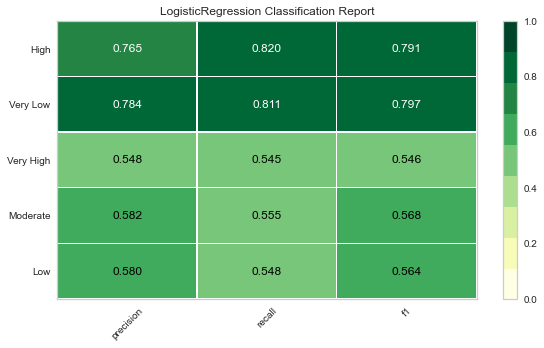

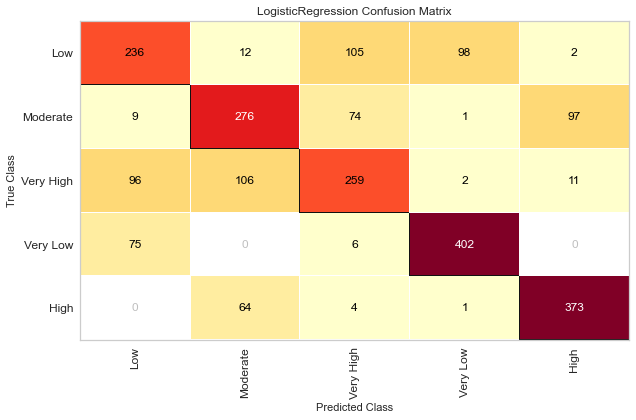

LogisticRegression() Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE LogisticRegressionCV: 0.6981377219575574


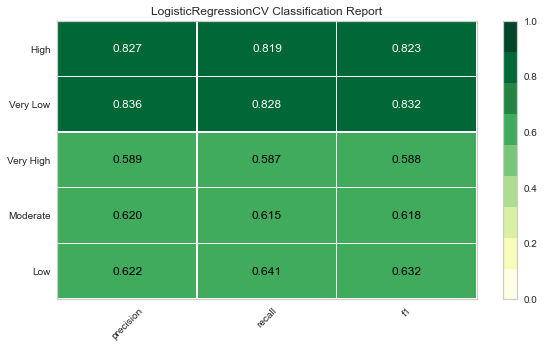

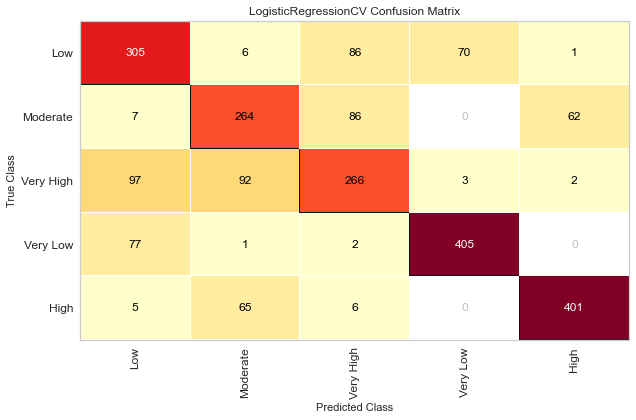

LogisticRegressionCV(cv=3) Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE BaggingClassifier: 0.9868341273278476


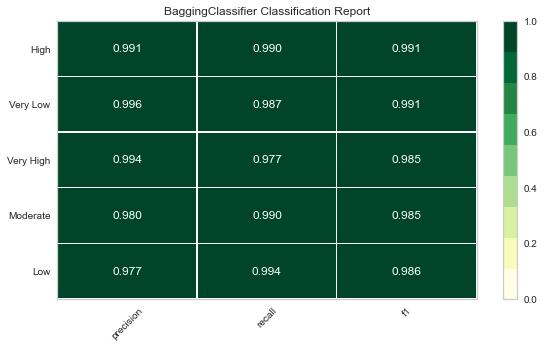

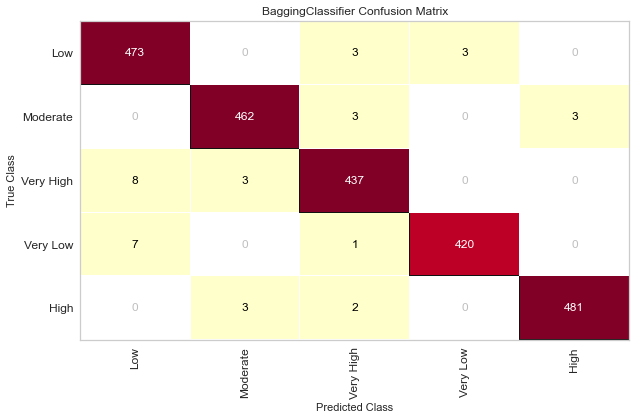

BaggingClassifier() Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE ExtraTreesClassifier: 0.9999133824166305


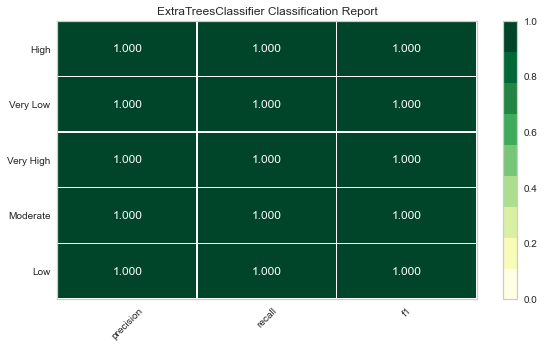

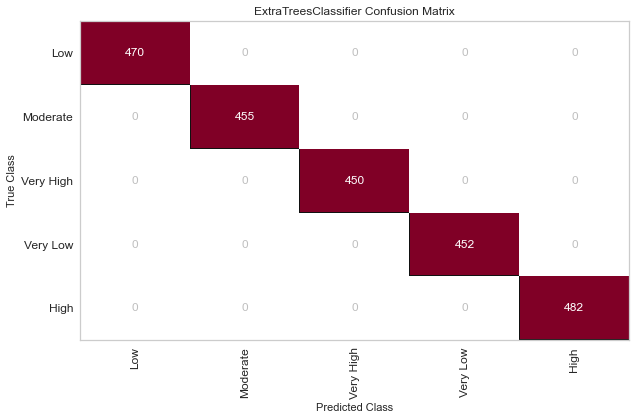

ExtraTreesClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable
F1 SCORE RandomForestClassifier: 0.9999133824166305


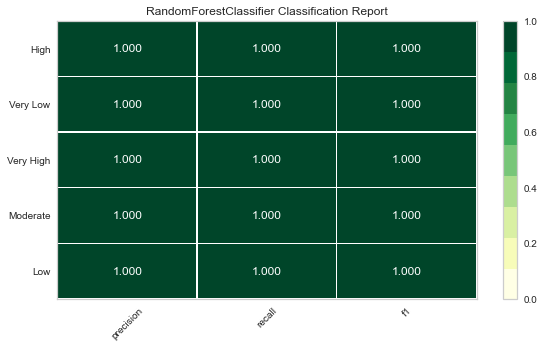

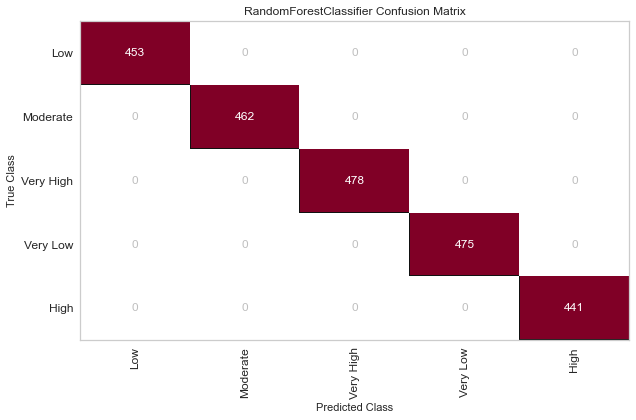

RandomForestClassifier(n_estimators=300) Traceback (most recent call last):
  File "<ipython-input-18-4b147f54996d>", line 9, in <module>
    conf_matrix(X, y, model,cat_labels)
  File "<ipython-input-16-fba14d021d06>", line 26, in conf_matrix
    plt.tight_layout()
TypeError: 'module' object is not callable
 'module' object is not callable


In [18]:
data = class_balance(est,'Child Opportunity Levels, overall COI, nationally-normed')
X = data.loc[:, data.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = data['Child Opportunity Levels, overall COI, nationally-normed']
train_test(X,y)
for model in models:
    try:
        score_model(X, y, model)
        visualize_model(X, y, model, cat_labels)
        conf_matrix(X, y, model,cat_labels)
    except Exception as exc:
        print(model, 
              traceback.format_exc(), 
              exc)